In [1]:
%env KERAS_BACKEND=torch

env: KERAS_BACKEND=torch


In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Embedding, LSTM, BatchNormalization
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.regularizers import l2



import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import re

In [3]:
nltk.download('stopwords')
snow_stemmer = SnowballStemmer(language='english')

[nltk_data] Downloading package stopwords to /home/radu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Global variables
image_size = (100, 100)
embedding_dim = 256
lstm_units = 256
batch_size = 32
num_classes = 2


In [5]:
# Modified: Added data augmentation function
def augment_images(image_data):
    """Apply data augmentation to images."""
    augmented_images = []
    for img in image_data:
        # Add random flip
        if np.random.rand() > 0.5:
            img = np.fliplr(img)
        # Add random rotation
        angle = np.random.randint(-15, 15)
        img = Image.fromarray((img * 255).astype(np.uint8)).rotate(angle)
        augmented_images.append(np.array(img) / 255.0)  # Normalize again
    return np.array(augmented_images)

### Loading images

In [6]:
def load_images(folder_path):
    """Load and preprocess images from a folder."""
    image_data = []
    for folder in folder_path:
        files = [f for f in os.listdir(folder) if f.endswith('.jpg')]
        for file_name in tqdm(files, desc=f"Loading images from folder {folder}"):
            file_path = os.path.join(folder, file_name)
            img = Image.open(file_path)
            if img.mode != "RGB":
                img = img.convert("RGB")
            img = img.resize(image_size)
            img_arr = np.array(img) / 255.0  # Normalize
            image_data.append(img_arr)
    #augment_images(image_data)
    return np.array(image_data)

### Preprocess text

In [7]:
def preprocess_captions(captions):
    """Preprocess captions by removing stopwords, punctuation, and stemming."""
    stop_words = set(stopwords.words('english'))
    processed_captions = []
    for sentence in captions:
        sentence = re.sub(r'[^\w\s]', '', sentence)  # Remove punctuation
        tokens = word_tokenize(sentence)
        tokens = [snow_stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words]
        processed_captions.append(' '.join(tokens))
    return processed_captions

In [8]:

def map_words_to_ids(captions):
    """Map unique words in captions to unique IDs."""
    mapped_ids = {}
    k = 0
    for sentence in captions:
        for word in sentence.split():
            if word not in mapped_ids:
                mapped_ids[word] = k
                k += 1
    return mapped_ids

In [9]:
def encode_captions(captions, word_map):
    """Encode captions into sequences of IDs, dynamically adding new words."""
    for caption in captions:
        for word in caption.split():
            if word not in word_map:
                word_map[word] = len(word_map)  # Add new word to the map
    return [[word_map[word] for word in caption.split()] for caption in captions]


In [10]:
def align_image_features(image_features, df):
    """Align image features based on image IDs in the dataset."""
    unique_image_ids = df['image_id'].unique()
    image_id_to_index = {img_id: idx for idx, img_id in enumerate(unique_image_ids)}
    aligned_features = [image_features[image_id_to_index[img_id]] for img_id in df['image_id']]
    return np.array(aligned_features)

In [11]:

def build_cnn_model():
    """Build an enhanced CNN model for image feature extraction."""
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(100, 100, 3)))
    model.add(BatchNormalization())  # Added Batch Normalization
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    return model

In [12]:
def extract_image_features(image_data, model):
    """Extract features from images using the CNN model."""
    #feature_extractor = Sequential(model.layers[:-1])
    return model.predict(image_data)

In [13]:
def build_lstm_model(vocab_size, max_length):
    """Build an enhanced LSTM model for text feature extraction."""
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Dropout(0.2))  # Prevent co-adaptation of word embeddings
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    return model

In [37]:
def train_combined_model(x_train, y_train, x_val, y_val):
    """Train a dense model on combined features."""
    model = Sequential()
    model.add(Dense(2048, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, batch_size=64)
    return model

In [25]:
# Load datasets
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')
test = pd.read_csv('test.csv')

# Load and preprocess images
train_image_data = load_images(['./train_images'])
val_image_data = load_images(['./val_images'])

Loading images from folder ./val_images: 100%|██████████| 2957/2957 [00:00<00:00, 3212.02it/s]


In [38]:
# Build and extract image features
cnn_model = build_cnn_model()
train_image_features = extract_image_features(train_image_data, cnn_model)
val_image_features = extract_image_features(val_image_data, cnn_model)
np.save('train_image_features.npy', train_image_features)
np.save('val_image_features.npy', val_image_features)

/home/radu/miniforge3/envs/ML/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


296/296 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


In [39]:
# Preprocess captions
train['processed_caption'] = preprocess_captions(train['caption'])
val['processed_caption'] = preprocess_captions(val['caption'])
test['processed_caption'] = preprocess_captions(test['caption'])

# Combine all captions
all_captions = list(train['processed_caption']) + list(val['processed_caption']) + list(test['processed_caption'])
# Map words to IDs
mapped_ids = map_words_to_ids(all_captions)

# Encode captions
train_caption_ids = encode_captions(train['processed_caption'], mapped_ids)
val_caption_ids = encode_captions(val['processed_caption'], mapped_ids)
test_caption_ids = encode_captions(test['processed_caption'], mapped_ids)

# Pad sequences
max_length = max([len(seq) for seq in train_caption_ids])
train_padded = pad_sequences(train_caption_ids, maxlen=max_length, padding='post')
val_padded = pad_sequences(val_caption_ids, maxlen=max_length, padding='post')


In [40]:
# Build and extract text features
vocab_size = len(mapped_ids)
lstm_model = build_lstm_model(vocab_size, max_length)
train_lstm_features = lstm_model.predict(train_padded)
val_lstm_features = lstm_model.predict(val_padded)
np.save('train_lstm_features.npy', train_lstm_features)
np.save('val_lstm_features.npy', val_lstm_features)

  5/313 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step

/home/radu/miniforge3/envs/ML/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


In [41]:
# Align image features to captions
train_aligned_image_features = align_image_features(train_image_features, train)
val_aligned_image_features = align_image_features(val_image_features, val)

In [42]:
# Combine features
train_combined_features = np.concatenate((train_aligned_image_features, train_lstm_features), axis=1)
val_combined_features = np.concatenate((val_aligned_image_features, val_lstm_features), axis=1)

scaler = StandardScaler()
train_combined_features = scaler.fit_transform(train_combined_features)
val_combined_features = scaler.transform(val_combined_features)

# One-hot encode labels
train_labels = to_categorical(train['label'].values, num_classes=num_classes)
val_labels = to_categorical(val['label'].values, num_classes=num_classes)

train_labels_binary = np.argmax(train_labels, axis=1)  # Convert one-hot to binary labels
val_labels_binary = np.argmax(val_labels, axis=1)


In [43]:
# Train model
model = train_combined_model(train_combined_features, train_labels_binary, val_combined_features, val_labels_binary)

Epoch 1/15
 12/157 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5229 - loss: 1.1378

/home/radu/miniforge3/envs/ML/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5483 - loss: 0.8109 - val_accuracy: 0.5713 - val_loss: 0.6925
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5825 - loss: 0.6782 - val_accuracy: 0.5630 - val_loss: 0.6852
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6301 - loss: 0.6520 - val_accuracy: 0.5750 - val_loss: 0.6897
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6655 - loss: 0.6185 - val_accuracy: 0.5790 - val_loss: 0.7029
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6811 - loss: 0.5857 - val_accuracy: 0.5807 - val_loss: 0.7185
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6965 - loss: 0.5771 - val_accuracy: 0.5663 - val_loss: 0.7717
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7281 - loss: 0.5289 - val_accuracy: 0.5683 - val_loss: 0.7875
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7667 - loss: 0.4756 - val_accuracy: 0.571

KeyboardInterrupt: 

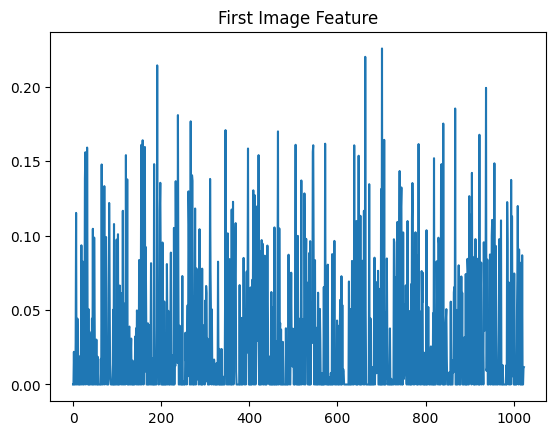

In [32]:
# Visualize the first image feature
import matplotlib.pyplot as plt

plt.plot(train_image_features[0])
plt.title("First Image Feature")
plt.show()


In [33]:
# Print the first text feature
print("First text feature vector:", train_lstm_features[0])

First text feature vector: [0.00214969 0.0088923  0.         ... 0.00681698 0.00231647 0.        ]


In [34]:
# Preprocess test captions
test['processed_caption'] = preprocess_captions(test['caption'])

# Pad sequences for LSTM
test_padded = pad_sequences(test_caption_ids, maxlen=max_length, padding='post')

# Extract test LSTM features
test_lstm_features = lstm_model.predict(test_padded)

# Load and preprocess test images
test_image_data = load_images(['./test_images'])
test_image_features = extract_image_features(test_image_data, cnn_model)

# Align test image features with test.csv
test_aligned_image_features = align_image_features(test_image_features, test)

# Combine test features
test_combined_features = np.concatenate((test_aligned_image_features, test_lstm_features), axis=1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


Loading images from folder ./test_images: 100%|██████████| 1978/1978 [00:00<00:00, 3066.63it/s]


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


In [35]:
# Make predictions
test_predictions = model.predict(test_combined_features)

# Convert probabilities to binary labels
test_labels = (test_predictions > 0.5).astype(int).flatten()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [36]:
# Create submission
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['label'] = test_labels  # Update 'label' column with predictions

# Save submission file
submission_path = 'submission.csv'
sample_submission.to_csv(submission_path, index=False)

print(f"Submission file created: {submission_path}")

Submission file created: submission.csv


### Expepriments

In [44]:
print("Class distribution in training labels:", np.bincount(train_labels_binary))
print("Class distribution in validation labels:", np.bincount(val_labels_binary))


Class distribution in training labels: [5000 5000]
Class distribution in validation labels: [1500 1500]


In [52]:
print("Mean of train_combined_features:", np.mean(train_combined_features, axis=0))
print("Std deviation of train_combined_features:", np.std(train_combined_features, axis=0))


Mean of train_combined_features: [ 7.1674583e-10  2.9712914e-09 -2.0229816e-08 ... -3.1371155e-07
 -3.9089173e-07  1.1891126e-08]
Std deviation of train_combined_features: [1.0000001  0.99999845 1.0000023  ... 1.0000511  0.9999823  0.99999964]


In [55]:
# Print feature shapes
print("Shape of Image Features:", train_image_features.shape)
print("Shape of LSTM Features:", train_lstm_features.shape)
print("Shape of Combined Features (Train):", train_combined_features.shape)
print("Shape of Combined Features (Validation):", val_combined_features.shape)
print("Shape of Combined Features (Test):", test_combined_features.shape)

# Print example combined features
print("First Combined Feature (Train):", train_combined_features[0])
print("First Combined Feature (Validation):", val_combined_features[0])

Shape of Image Features: (9463, 1024)
Shape of LSTM Features: (10000, 1024)
Shape of Combined Features (Train): (10000, 2048)
Shape of Combined Features (Validation): (3000, 2048)
Shape of Combined Features (Test): (2000, 2048)
First Combined Feature (Train): [ 1.1415048   1.4631248   0.85797757 ... -0.02460239 -0.01245795
  0.623907  ]
First Combined Feature (Validation): [ 1.7528973   1.8607658   3.6521046  ... -0.02460239 -0.01245795
 -0.679667  ]


In [56]:
# Check alignment of image and text features
print("First Image Feature (Train):", train_image_features[0])
print("First LSTM Feature (Train):", train_lstm_features[0])
print("Corresponding Combined Feature:", train_combined_features[0])

# Confirm alignment with captions
print("First Caption (Train):", train['processed_caption'].iloc[0])
print("First Label (Train):", train_labels_binary[0])

First Image Feature (Train): [0.07949073 0.14582914 0.04804631 ... 0.         0.         0.        ]
First LSTM Feature (Train): [0.         0.         0.00066396 ... 0.         0.         0.0007302 ]
Corresponding Combined Feature: [ 1.1415048   1.4631248   0.85797757 ... -0.02460239 -0.01245795
  0.623907  ]
First Caption (Train): wet eleph shake water onto peopl bath
First Label (Train): 0


In [57]:
# Visualize first 5 captions with their combined features
for i in range(5):
    print(f"Caption {i+1}: {train['processed_caption'].iloc[i]}")
    print(f"Combined Feature {i+1}: {train_combined_features[i]}")
    print(f"Label {i+1}: {train_labels_binary[i]}")
    print("-" * 50)

Caption 1: wet eleph shake water onto peopl bath
Combined Feature 1: [ 1.1415048   1.4631248   0.85797757 ... -0.02460239 -0.01245795
  0.623907  ]
Label 1: 0
--------------------------------------------------
Caption 2: two men hold tenni racquet court
Combined Feature 2: [ 1.7528973   1.8607658   3.6521046  ... -0.02460239 -0.01245795
  0.7389239 ]
Label 2: 0
--------------------------------------------------
Caption 3: bird tree limb mountain background
Combined Feature 3: [-0.16754387  1.5710789  -0.76670355 ... -0.02460239 -0.01245795
 -0.73878545]
Label 3: 0
--------------------------------------------------
Caption 4: kitchen dine room featur along larg dine room tabl kitchen applianc chandeli
Combined Feature 4: [ 1.1427628   0.21705166 -0.19542582 ... -0.02460239 -0.01245795
  1.0170623 ]
Label 4: 0
--------------------------------------------------
Caption 5: fruit stand various fruit tabl
Combined Feature 5: [ 0.28843856 -0.24785925 -1.469196   ... -0.02460239 -0.01245795
 -

In [58]:
# Analyze distribution of combined features
print("Mean of Combined Features (Train):", np.mean(train_combined_features, axis=0))
print("Standard Deviation of Combined Features (Train):", np.std(train_combined_features, axis=0))


Mean of Combined Features (Train): [ 7.1674583e-10  2.9712914e-09 -2.0229816e-08 ... -3.1371155e-07
 -3.9089173e-07  1.1891126e-08]
Standard Deviation of Combined Features (Train): [1.0000001  0.99999845 1.0000023  ... 1.0000511  0.9999823  0.99999964]


In [59]:
# Check variance of combined features
print("Variance of Combined Features (Train):", np.var(train_combined_features, axis=0))


Variance of Combined Features (Train): [1.0000002  0.99999696 1.0000046  ... 1.0001023  0.99996465 0.99999934]
